# Please upvote if useful 🔥🔥🔥
## Author: Rishi Chandra  @sapthrishi007

# This is NOT an alternative to YOLO type object detection

# This is simple image classification using resnet with soft attention (CBAM) pretrained on imagenet and demonstrates the following:

## 1. Grad-Cam visualization of the final CNN layer feature map and localizing the bounding box on the image which mostly activates this feature map.

## 2. Using this bounding box for the submission. Obviously this is not a replacement to yolo since the model does not trains on the input bounding boxes of the training set.

## 3. Soft attention CBAM: Convolutional Block Attention Module 

CBAM paper ref: https://arxiv.org/pdf/1807.06521.pdf

CBAM resnet github: https://github.com/Jongchan/attention-module

## 4. A reusable custom Trainer with plots a variety of metrics. Trains it through Progressive Resizing of image, and checkoints best model for a variety of metrics. You can reuse this trainer for your projects too!!!

## 5. Resume training from last epoch, model and optimizer state, by just specifying the last checkpoint !  Also adjust no. of cycles and plot ur lr curve and see.

## 6. Searches for an optimum probability threshold, instead of default 0.5, for image classification. The trainer is for scenario of MultiLabelBinaryClassification, and can easily be tweaked for any scenario.

## 7. Uses sum of DiceLoss and BCEWithLogitsLoss. DiceLoss to take care of class sparcity, class unbalance. And class weighted BCEWithLogitsLoss for class imbalance and smoother gradients.

## 8. Just specify your model path in torch.load(...) statements and infer from your model


Today is Holi, Wish you Happy Holi !!!

In [1]:
!export HOROVOD_WITH_PYTORCH=1 
!pip install horovod[pytorch]

     |████████████████████████████████| 3.2 MB 2.9 MB/s eta 0:00:01
  Created wheel for horovod: filename=horovod-0.21.3-cp37-cp37m-linux_x86_64.whl size=26931603 sha256=9661c6715c342e5d86d4beabd35e7f861d9f7d4ee15a05af0b7d28af74ef0e0b
  Stored in directory: /root/.cache/pip/wheels/31/c9/f4/7327ba40c2228c71276bccf9dec67b2601588033e19e05470b
Successfully built horovod


In [2]:
!ls ../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/pred_probs.pt
!ls ../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_1024_fold0.pth
!cp ../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_1024_fold0.pth ./
!cp ../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_1024_fold0.pth ./cbam_resnet50_fold0_start.pth

ls: cannot access '../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/pred_probs.pt': No such file or directory
../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_1024_fold0.pth


In [3]:
!ls ../input/vinbigdata-chest-xray-resized-png-1024x1024/

test  train  train_meta.csv


In [4]:
# !pip install GPUtil

In [5]:
# import sys
# sys.path.append ('/kaggle/input/pytorch-images-seresnet')
import os
import gc
import time
import math
import random
import datetime
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
from   torch.nn import init
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from   torch.nn import Parameter
from   torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from   transformers import AdamW, get_cosine_schedule_with_warmup
from   torch.cuda.amp import autocast, GradScaler

from   fastai.losses import LabelSmoothingCrossEntropy

# from warmup_scheduler import GradualWarmupScheduler
from   sklearn import preprocessing
from   sklearn.metrics import accuracy_score
from   sklearn.model_selection import StratifiedKFold, GroupKFold
from   sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, roc_auc_score
from   sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

# import timm
import albumentations as A
from   albumentations import *
from   albumentations.pytorch import ToTensorV2
from   albumentations.core.transforms_interface import DualTransform
from   albumentations.augmentations import functional as AF
import cv2

from   tqdm import tqdm
from   pprint import pprint
from   functools import partial
import matplotlib.pyplot as plt
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

import horovod.torch as hvd

import warnings
warnings.filterwarnings ("ignore")

In [6]:
class CFG:
    device       = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')
    num_workers  = 8
    model_name   = 'cbam_resnet50'        # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b7_ns']
    size         = 640                    # [64, 128, 224, 384, 512, 640, 720]
    isTrain      = True
    isFreeze     = True
    lr           = 1e-3
    epochs       = 6
    warmup_steps = 0.50                    # if float: these many epochs are with frozen model at the beginning, if int = actual steps
    lr_num_cycles= 2.5
    epochsNx     = 1
    criterion    = 'dice_bce'              # ['dice_bce', CrossEntropyLoss', 'BCEWithLogitsLoss', 'SmoothBCEwithLogits']
    weight_decay = 1e-6
    max_grad_norm= 1000.0
    seed         = 42
    n_fold       = 10
    train_fold   = [0]                      # [0, 1, 2, 3, 4]
    print_every  = 100
    adam_epsilon = 1e-8
    train_batch_size = 12
    eval_batch_size  = 112
    img_ext          = '.png'
    img_col          = "image_id"
    raw_label_cols   = 'class_id'
    label_cols       = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    target_size      = len (label_cols)
    model_infer_path_prefix = "."
    model_train_path_prefix = "."
    train_path       = '../input/vinbigdata-chest-xray-resized-png-1024x1024/train'
    train_csv        = '../input/vinbigdata-chest-xray-abnormalities-detection/train.csv'
    test_path        = '../input/vinbigdata-chest-xray-resized-png-1024x1024/test'
    output_dir       = './results'        # output directory    
    eval_steps       = 0.5                # if float: these many epochs are with frozen model at the beginning, if int = actual steps 
    max_steps        = 0
    MODEL            = None
    thresholds       = [0.5, 0.01, 0.001, 0.1, 0.01, 0.001, 0.01, 0.001, 0.001, 0.0001, 0.1, 0.1, 0.01, 0.1]
    lr_scaler        = 1
    
    IMG_MEAN         = [0.485, 0.456, 0.406] #Mean for normalization Transform cassava = [0.4303, 0.4967, 0.3134] imgnet = [0.485, 0.456, 0.406]
    IMG_STD          = [0.229, 0.224, 0.225] #STD for normalization Transform cassava = [0.2142, 0.2191, 0.1954] imgnet = [0.229, 0.224, 0.225]

In [7]:
def init_logger (log_file=CFG.output_dir+'train.log'):
    
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger (__name__)
    logger.setLevel (INFO)
    handler1 = StreamHandler ()
    handler1.setFormatter (Formatter ("%(message)s"))
    handler2 = FileHandler (filename=log_file)
    handler2.setFormatter (Formatter ("%(message)s"))
    logger.addHandler (handler1)
    logger.addHandler (handler2)
    return logger

In [8]:
def seed_everything (seed):
    
    random.seed (seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    return

In [9]:
def preprocess_train_csv ():
    
    df    = pd.read_csv (CFG.train_csv).reset_index (drop=True)
    cols  = [CFG.img_col] + [CFG.raw_label_cols]               #;print (df[CFG.raw_label_cols])
    df    = df[cols]                                             #;print ('df.shape =', df.shape, df.iloc[0,1])
    no_df = df.loc[df[CFG.raw_label_cols] == 14]
    df    = df.loc[df[CFG.raw_label_cols] != 14]                 #;print ('df.shape =', df.shape, df[CFG.raw_label_cols]!=14)
    df    = df.append (no_df.sample (n=500, random_state=CFG.seed))
    del no_df
    
    dg       = df.groupby (CFG.img_col)
    df_dicts = []
    for k in dg:
        # print (k[0], list(k[1]['class_id']))
        row = {CFG.img_col:k[0]}
        for cat in range(14):
            row[cat] = 0
        for cat in list(k[1]['class_id']):
            if cat != 14:
                row[cat] = 1
        df_dicts.append (row)
    df = pd.DataFrame.from_dict (df_dicts)
    # df.head ()
    return df

In [10]:
junk = preprocess_train_csv ()
junk.head ()

,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0005e8e3701dfb1dd93d53e2ff537b6e,0,0,0,0,1,0,1,1,1,0,0,0,0,0
1,0007d316f756b3fa0baea2ff514ce945,1,0,0,1,0,1,0,0,0,0,0,1,0,1
2,000d68e42b71d3eac10ccc077aba07c1,1,0,0,0,0,0,0,1,0,1,0,1,0,1
3,00150343289f317a0ad5629d5b7d9ef9,1,0,0,1,0,0,0,1,0,1,1,1,0,1
4,001d127bad87592efe45a5c7678f8b8d,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [11]:
del junk; gc.collect ()

35

# Augmentation Dataset

In [12]:
# Dual Cutout implementations
class CutoutV2 (A.DualTransform):
    def __init__(
        self,
        num_holes=8,
        max_h_size=8,
        max_w_size=8,
        fill_value=0,
        always_apply=False,
        p=0.5,
    ):
        super(CutoutV2, self).__init__(always_apply, p)
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size
        self.fill_value = fill_value

    def apply(self, image, fill_value=0, holes=(), **params):
        return A.functional.cutout(image, holes, fill_value)

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        height, width = img.shape[:2]

        holes = []
        for _n in range(self.num_holes):
            y = random.randint(0, height)
            x = random.randint(0, width)

            y1 = np.clip(y - self.max_h_size // 2, 0, height)
            y2 = np.clip(y1 + self.max_h_size, 0, height)
            x1 = np.clip(x - self.max_w_size // 2, 0, width)
            x2 = np.clip(x1 + self.max_w_size, 0, width)
            holes.append((x1, y1, x2, y2))

        return {"holes": holes}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return ("num_holes", "max_h_size", "max_w_size")

In [13]:
# NOTE: We don't normalize here since it all gets dark
# if advprop:           # for models using advprop pretrained weights
#     normalize = transforms.Lambda(lambda img: img * 2.0 - 1.0)
# else:
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def get_transforms (data='train'):
    
    light_transforms = A.Compose ([
        A.Resize (CFG.size, CFG.size),
        A.HorizontalFlip (p=0.5),
        A.HueSaturationValue (hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast (brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.augmentations.transforms.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5),
        A.augmentations.transforms.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
        A.augmentations.transforms.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
        A.CoarseDropout(p=0.5),
        A.Cutout (max_h_size=int(CFG.size * 0.2), max_w_size=int(CFG.size * 0.2), num_holes=2, p=0.75),
        # A.Normalize (),
        # ToTensorV2 (p=1.0),
    ])

    heavy_transforms = A.Compose ([
        A.RandomResizedCrop(CFG.size, CFG.size, scale=(0.9, 1), p=1), 
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
        A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
        A.CLAHE(clip_limit=(1,4), p=0.5),
        A.OneOf([
           A.OpticalDistortion(distort_limit=1.0),
           A.GridDistortion(num_steps=5, distort_limit=1.),
           A.ElasticTransform(alpha=3),
        ], p=0.2),
        A.OneOf([
           A.GaussNoise(var_limit=[10, 50]),
           A.GaussianBlur(),
           A.MotionBlur(),
           A.MedianBlur(),
        ], p=0.2),
        A.Resize(CFG.size, CFG.size),
        A.OneOf([
          JpegCompression(),
          Downscale(scale_min=0.1, scale_max=0.15),
        ], p=0.2),
        IAAPiecewiseAffine(p=0.2),
        IAASharpen(p=0.2),
        CutoutV2 (max_h_size=int(CFG.size * 0.4), max_w_size=int(CFG.size * 0.4), num_holes=1, p=0.75),
        # A.Normalize(),
        # ToTensorV2 (p=1.0),
    ])

    train_transform = A.OneOf ([
        light_transforms,
        heavy_transforms,
    ], p=1)

    valid_transforms = A.Compose ([
        A.Resize (CFG.size, CFG.size),
        # A.Normalize (),
        # ToTensorV2 (p=1.0),
    ])
    
        
    if 'train' in data:
        return light_transforms # train_transform, heavy_transforms
    elif 'valid' in data:
        return valid_transforms
    return valid_transforms

In [14]:
class ImgDataset (Dataset):
    
    def __init__(self, df, img_file_colname=CFG.img_col, label_cols=CFG.label_cols, 
                 transform=get_transforms(), img_dir=CFG.train_path, img_ext=CFG.img_ext):
        
        super ().__init__()
        self.df               = df.reset_index (drop=True)
        self.img_ext          = CFG.img_ext
        self.img_dir          = img_dir
        self.label_cols       = label_cols
        self.img_file_colname = img_file_colname
        self.transform        = transform
        return
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        
        file_name = self.df[self.img_file_colname][idx].replace (self.img_ext, '') + self.img_ext
        file_path = f'{self.img_dir}/{file_name}'
        image     = cv2.imread (file_path)[:, :, ::-1]                         #;print (image.shape)
        image     = self.transform (image=image)['image']
        image     = image.astype (np.float32).transpose (2, 0, 1) / 255.0
        image     = torch.tensor (image).float ()
        if len (self.label_cols) > 0:
            
            label = torch.tensor (self.df.loc[idx, self.label_cols]).float () # long ()
            return image, label
        return image

In [15]:
def getFolds ():
    
    train_folds_df = preprocess_train_csv () # pd.read_csv (CFG.train_csv)
    label = train_folds_df[CFG.label_cols]
    if len (CFG.label_cols) > 1:
        label = train_folds_df[CFG.label_cols[0]]
        
    skf = StratifiedKFold (n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate (skf.split (train_folds_df, label)):
        train_folds_df.loc[val_index, 'fold'] = int (n)
    train_folds_df['fold'] = train_folds_df['fold'].astype (int)
    # print (train_folds_df.groupby (['fold', label]).size ())
        
    return train_folds_df

0

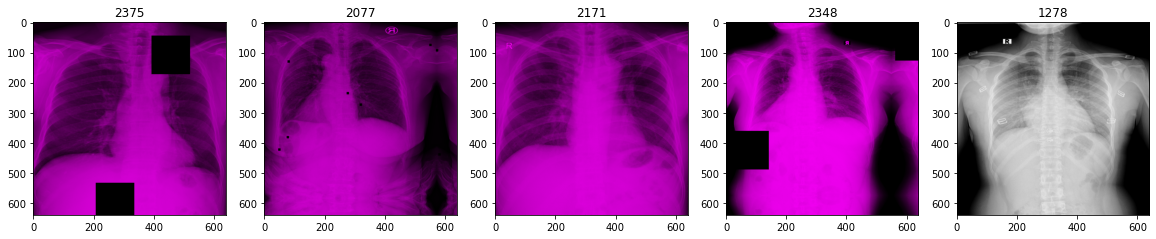

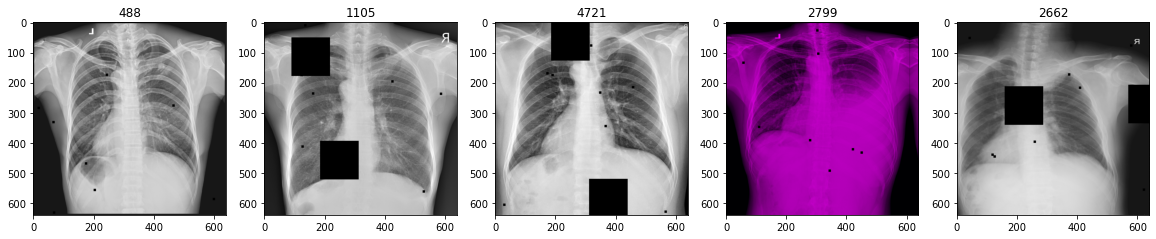

In [16]:
def plot_imgs (dataset_show):
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range (2):
        f, axarr = plt.subplots (1,5)
        for p in range (5):
            idx = np.random.randint (0, len (dataset_show))
            img, label = dataset_show[idx]                         # ;print (img.size()) ;print (label)
            # img = img.byte ()
            axarr[p].imshow (img.permute(1, 2, 0))
            axarr[p].set_title (idx)
    return

TR_DATASET = ImgDataset (getFolds (), transform=get_transforms())
plot_imgs (TR_DATASET)
del TR_DATASET
gc.collect ()

> # Loss Functions

In [17]:
# this works for only 1 label, not multi-label target.
class SmoothBCEwLogits (_WeightedLoss):
    
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [18]:
class DiceBCELoss (nn.Module):
    
    def __init__(self, class_wt=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bceWithLogitsLoss = nn.BCEWithLogitsLoss (pos_weight=class_wt)

    def forward(self, logits, targets, smooth=1):
        
        #flatten label and prediction tensors
        logits_flat  = logits.view(-1)                   #;print ("logits.shape =", logits.shape)
        targets_flat = targets.view(-1)                  #;print ("targets.shape =", targets.shape)
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid (logits_flat)                 #;print ("inputs.shape =", inputs.shape)
        
        intersection = (inputs * targets_flat).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets_flat.sum() + smooth)  
        BCE = self.bceWithLogitsLoss (logits, targets)
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [19]:
def get_criterion (class_wt):
    
    if CFG.criterion=='CrossEntropyLoss':
        criterion = LabelSmoothingCrossEntropy ()
    elif CFG.criterion=='SmoothBCEwithLogits':
        criterion = SmoothBCEwLogits (smoothing=CFG.smoothing)
    elif CFG.criterion=='BCEWithLogitsLoss':
        criterion =  nn.BCEWithLogitsLoss (pos_weight=class_wt)
    elif CFG.criterion=='dice_bce':
        criterion = DiceBCELoss (class_wt=class_wt)
    return criterion

# CBAM
https://github.com/Jongchan/attention-module

In [20]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

# ResNet50 Model

In [21]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes * 4, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers,  network_type, num_classes, att_type=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.network_type = network_type
        # different model config between ImageNet and CIFAR 
        if network_type == "ImageNet":
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            self.bam1 = BAM(64*block.expansion)
            self.bam2 = BAM(128*block.expansion)
            self.bam3 = BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None

        self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type)

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0
        
        self.pooling = nn.AdaptiveAvgPool2d (1)
        return

    def _make_layer(self, block, planes, blocks, stride=1, att_type=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM'))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM'))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.network_type == "ImageNet":
            x = self.maxpool(x)

        x = self.layer1(x)
        if not self.bam1 is None:
            x = self.bam1(x)

        x = self.layer2(x)
        if not self.bam2 is None:
            x = self.bam2(x)

        x = self.layer3(x)
        if not self.bam3 is None:
            x = self.bam3(x)

        x = self.layer4(x)
        
        
        if self.network_type == "ImageNet":
            x  = self.pooling (x)
        else:
            x = F.avg_pool2d(x, 4)
        x = x.view (x.size (0), -1)
        x = self.fc (x)
        return x
    
    def freeze (self):
        # To freeze the residual layers
        for param in self.parameters ():
            param.requires_grad = False

        for param in self.fc.parameters ():
            param.requires_grad = True
        return
    
    def unfreeze (self):
        # Unfreeze all layers
        for param in self.parameters ():
            param.requires_grad = True
        for param in self.fc.parameters ():
            param.requires_grad = True
        return

def getResNet (network_type="ImageNet", depth=50, num_classes=CFG.target_size, att_type="CBAM"):

    assert network_type in ["ImageNet", "CIFAR10", "CIFAR100"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [50, 101], 'network depth should be 50 or 101'
    
    if depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], network_type, num_classes, att_type)

    return model

In [22]:
def fix_state_dict (sd):
    
    import re
    state_dict = dict ()
    for k in sd:
        k2 = re.sub (r'^module\.', '', k)
        # print (k2)
        state_dict[k2] = sd[k]
    return state_dict

In [42]:
def load_state (model_path, model):
    
    state_dict = None
    try:  # single GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu')) # ['state_dict']
        # print (state_dict)
        # state_dict = fix_state_dict (state_dict)
        model.load_state_dict (state_dict) # (torch.load (model_path, map_location=torch.device ('cpu')), strict=True)
    except:  # multi GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))
        state_dict = {k[7:] if k.startswith ('module.') else k: state_dict[k] for k in state_dict.keys ()}
        model.load_state_dict (state_dict)
    return state_dict

In [33]:
def getModel (fold, isTrain=True):
    
    model = getResNet ("ImageNet", 50, CFG.target_size, "CBAM")
    if isTrain:
        
        # TODO: _infer_ to _train_,   _end to _maxacc
        model_path = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_start.pth'
        print ("loading", model_path)
        load_state (model_path, model)
        
        # replace the imagenet head with Vin head
        # n_features = model.fc.in_features
        # model.model.global_pool = nn.Identity ()
        # model.fc = nn.Identity ()
        # model.pooling = nn.AdaptiveAvgPool2d (1)
        # model.fc_new = nn.Linear (n_features, CFG.target_size)
    else:
        
        # model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}_maxacc.pth'
        # load_state (model_path, model)
        pass
    
    # torch.save (model.state_dict (), model_path)
    if CFG.isFreeze:        
        model.freeze ()
    else:
        model.unfreeze ()
    return model

## Trainer Helpers

In [34]:
def format_time (elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str (datetime.timedelta (seconds=elapsed_rounded))

In [35]:
def sigmoid (x):  
    return np.exp (-np.logaddexp (0, -x))

def compute_metrics (labels, pred_pr, threshold=None):
    
    preds   = pred_pr.argmax (-1)
    if threshold is not None:
        preds = pred_pr[:,1] >= threshold
    print ('labels.shape=', labels.shape, 'preds.shape=', preds.shape, '#P+ve=', np.sum (preds), '#A+ve=', np.sum (labels))   #TODO: comment this
    precision, recall, f1, _ = precision_recall_fscore_support (labels, preds, average='binary')
    acc     = accuracy_score (labels, preds)
    mcc     = matthews_corrcoef (labels, preds)   # matthews correlation coefficient
    auc     = -1
    try:
        auc = roc_auc_score (labels, pred_pr[:, 1])
    except:
        pass
    metrics = {
        'mcc'      : mcc,
        'accuracy' : acc,
        'f1'       : f1,
        'precision': precision,
        'recall'   : recall,
        'auc'      : auc
    }
    return metrics

def find_best_thresh (label, pred_p):
    
    scores = []
    thresholds = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5]
    for threshold in thresholds:
        
        score = compute_metrics (label, pred_p, threshold)
        score['threshold'] = threshold
        scores.append (score)
        
    df = pd.DataFrame (scores)            #;print (df)
    # df.set_index('threshold').plot.bar (rot=0, title='threshold vs scores', figsize=(80,10), fontsize=14)
    df = df.loc[df.f1 == df.f1.max ()]
    df = df.iloc[0, :]
    return df.to_dict ()

def compute_multilabel_binary_metrics (labels, pred_pr, isThreshAdjust=False):
    
    # pred_pr = sigmoid (logits)    
    metrics = []
    n_class = labels.shape[1]
    thresholds = []
    for i in range (n_class):
        
        label  = labels[:, i]
        prob1  = pred_pr[:, i]
        prob0  = 1 - prob1
        pred_p = np.hstack ((prob0.reshape ((-1, 1)), prob1.reshape ((-1, 1))))
        scores = None
        if isThreshAdjust:
            scores = find_best_thresh (label, pred_p)
            thresholds.append (scores['threshold'])
            print (f"for class-{i+1}/{n_class} maxF1 thresh={scores['threshold']}")
        else:
            scores = compute_metrics (label, pred_p)
        metrics.append (scores)
        
    # Now Avg over each classes
    metrics_df = pd.DataFrame (metrics)  
    auc = list (metrics_df['auc'].values)
    auc = np.mean ([a for a in auc if a >= 0])
    metrics_df.drop (columns=['auc'], inplace=True)
    metrics_df = metrics_df.mean ()
    metrics_df['auc'] = auc
    # print (metrics_df)                                       #TODO: comment this
    if isThreshAdjust:
        print ("class wise thresholds =", thresholds)
        CFG.thresholds = thresholds
    return metrics_df.to_dict ()

def metric_average (val, name):
    
    tensor = torch.tensor (val)
    avg_tensor = hvd.allreduce (tensor, name=name)
    return avg_tensor.item ()

# Trainer

In [36]:
class MyTrainer:
    
    def __init__(self, fold, model, train_dataset, eval_dataset, criterion, 
                 compute_metrics=compute_multilabel_binary_metrics, checkpoint_path=None, isResume=False):
        
        self.fold             = fold
        self.start_epoch      = 0
        self.model            = model
        # load checkpoint
        if checkpoint_path is not None:
            if isResume:
                self.start_epoch = self.load_checkpoint (checkpoint_path, isResume=True) + 1
            else:
                self.load_checkpoint (checkpoint_path, isResume=False)
        self.model            = self.model.to (CFG.device)
        if CFG.isFreeze:
            self.model.freeze ()
        else:
            self.model.unfreeze ()
        CFG.MODEL             = self.model
        self.train_dataset    = train_dataset
        self.eval_dataset     = eval_dataset
        self.criterion        = criterion
        self.compute_metrics  = compute_metrics
        self.isTrained        = False
        self.device           = CFG.device
        self.optimizer        = AdamW (self.model.parameters (), lr=CFG.lr*CFG.lr_scaler, eps=CFG.adam_epsilon, weight_decay=CFG.weight_decay)
        self.epochs           = CFG.epochs
        self.set_dataLoaders ()
        self.training_stats   = []
        self.modelFile        = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}.pth"
        if eval_dataset is not None:
            self.minLossModelFile = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_min_val_loss.pth"
            self.maxAucModelFile  = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_max_val_auc.pth"
        else:
            self.minLossModelFile = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_min_tr_loss.pth"
            self.maxAucModelFile  = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_max_tr_auc.pth"
        
        self.min_val_loss         = 9999
        self.min_train_loss       = 9999
        self.max_val_auc          = -1
        
        # Horovod: broadcast parameters & optimizer state.
        # Add Horovod Distributed Optimizer
        hvd.broadcast_parameters (self.model.state_dict(), root_rank=0)
        hvd.broadcast_optimizer_state (self.optimizer, root_rank=0)
        self.optimizer = hvd.DistributedOptimizer (self.optimizer, named_parameters=self.model.named_parameters ())
        return
    
    def set_dataLoaders (self):
        # Create the DataLoaders for our training and validation sets.
        train_sampler = torch.utils.data.distributed.DistributedSampler (
                            self.train_dataset, num_replicas=hvd.size (), rank=hvd.rank ())
        train_dataloader  = DataLoader (
                    self.train_dataset,                                  # The training samples.
                    sampler     = train_sampler,                           
                    batch_size  = CFG.train_batch_size,
                    num_workers = CFG.num_workers,
                    pin_memory  = True
        )
        
        validation_dataloader = None
        if self.eval_dataset:
            valid_sampler = torch.utils.data.distributed.DistributedSampler (
                            self.eval_dataset, num_replicas=hvd.size (), rank=hvd.rank ())
            validation_dataloader = DataLoader (
                        self.eval_dataset, 
                        sampler     = valid_sampler,
                        batch_size  = CFG.eval_batch_size,
                        num_workers = CFG.num_workers,
                        pin_memory  = False
            )
        
        if type (CFG.warmup_steps) is float:
            CFG.warmup_steps = int (CFG.warmup_steps * len (train_dataloader))
        # Total number of training steps is [number of batches] x [number of epochs]
        num_training_steps = len (train_dataloader) * self.epochs        
        lr_scheduler = get_cosine_schedule_with_warmup (self.optimizer, num_cycles=CFG.lr_num_cycles,
                        num_warmup_steps=CFG.warmup_steps, num_training_steps=num_training_steps)
        
        if type (CFG.eval_steps) is float:
            CFG.eval_steps = int (CFG.eval_steps * len (train_dataloader))
        self.train_dataloader, self.validation_dataloader, self.lr_scheduler, self.num_training_steps=train_dataloader, validation_dataloader, lr_scheduler, num_training_steps
        return
            
    def test_iterate_dataloader (self):
        
        for step, batch in enumerate (self.train_dataloader):
            print (step)
            print (batch)
            break
        return
    
    def save_checkpoint (self, epoch, path):
        
        if hvd.rank() != 0:
            return
        
        checkpoint = {
            'epoch'               : epoch,
            'model_state_dict'    : self.model.state_dict (),
            'optimizer_state_dict': self.optimizer.state_dict (),
            'lr_sched_state_dict' : self.lr_scheduler.state_dict (),
            'training_stats'      : self.training_stats,
            'max_val_auc'         : self.max_val_auc,
            'min_train_loss'      : self.min_train_loss,
            'min_val_loss'        : self.min_val_loss,
        }
        torch.save (checkpoint, path)
        gc.collect (); torch.cuda.empty_cache ()
        print ("saved checkpoint", path)
        return
    
    def load_checkpoint (self, path, isResume=False):
        
        epoch      = 0
        checkpoint = torch.load (path, map_location=torch.device ('cpu'))
        self.model.load_state_dict (checkpoint['model_state_dict'])
        if isResume:
            
            self.optimizer.load_state_dict (checkpoint['optimizer_state_dict'])
            self.lr_scheduler.load_state_dict (checkpoint['lr_sched_state_dict'])
            epoch = checkpoint['epoch']
            self.training_stats  = checkpoint['training_stats']
            self.min_val_loss    = checkpoint['min_val_loss']
            self.min_train_loss  = checkpoint['min_train_loss']
            self.max_val_auc     = checkpoint['max_val_auc']
            print ("Loaded model, optimizer, and lr_scheduler from -", path)
        else:
            print ("Loaded model from -", path)
            
        self.model.train ()
        return epoch
    
    def train (self):
        
        seed_everything (seed=CFG.seed)
        step             = 0
        total_t0         = time.time ()
        scaler           = GradScaler()
        for epoch_i in range (self.start_epoch, self.epochs):
            
            avg_epoch_train_loss   = 0
            total_epoch_train_loss = 0
            print('======== Epoch {:} / {:} ========'.format (epoch_i + 1, self.epochs))
            t0 = time.time ()
            self.model.train ()
            self.train_dataloader.sampler.set_epoch (epoch_i)
            for stp, batch in tqdm (enumerate (self.train_dataloader), total=len(self.train_dataloader)):
                
                # Print Stats
                # if step % CFG.print_every == 0:
                #     elapsed = format_time (time.time() - t0)
                #     print ('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format (step, len (self.train_dataloader), elapsed))                
                if ((CFG.max_steps > 0 and CFG.max_steps < step) or 
                    (CFG.eval_steps>0 and stp==CFG.eval_steps)): # or step==0):   # TODO: rm this comment
                    
                    self.save_checkpoint (epoch_i, self.modelFile)
                    training_time = format_time (time.time () - t0)            
                    if self.validation_dataloader:
                        
                        avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate (epoch_i, avg_epoch_train_loss, training_time)
                        # save this model if the eval loss decreases from the minimum so far
                        checkpoint_epoch = epoch_i
                        if stp==CFG.eval_steps:
                            # don't count this epoch in the checkpoint since this epoch 
                            # has not completed. Hence, checkpoint at prev epoch
                            checkpoint_epoch = epoch_i-1
                        if avg_val_loss < self.min_val_loss:                             
                            self.min_val_loss = avg_val_loss
                            self.save_checkpoint (checkpoint_epoch, self.minLossModelFile)
                        if avg_val_auc > self.max_val_auc:
                            self.max_val_auc = avg_val_auc
                            self.save_checkpoint (checkpoint_epoch, self.maxAucModelFile)
                    if CFG.max_steps > 0 and CFG.max_steps < step:
                        
                        print ("")
                        print ("Training complete!")
                        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
                        self.isTrained = True
                        self.model.cpu ()
                        self.model.eval ()
                        self.save_checkpoint (epoch_i, self.modelFile)
                        try:
                            torch.cuda.empty_cache ()
                            self.plot_train_stats (self.training_stats)
                        except:
                            pass
                        return pd.DataFrame (self.training_stats)
                
                ########################################################
                # Train
                ########################################################
                # self.model.zero_grad ()                        
                images = batch[0].to (self.device)
                labels = batch[1].to (self.device)
                with autocast():
                    
                    logits = self.model (images)
                    loss   = self.criterion (logits, labels)
                    torch.nn.utils.clip_grad_norm_ (self.model.parameters (), CFG.max_grad_norm)
                    scaler.scale (loss).backward ()
                    scaler.step (self.optimizer)
                    scaler.update ()
                    self.optimizer.zero_grad ()
                    self.lr_scheduler.step ()
                    
                total_epoch_train_loss += loss.cpu ().item ()
                avg_epoch_train_loss    = total_epoch_train_loss / (stp+1)
                step += 1
            # all steps of an epoch end
            
            # Measure how long this epoch took.
            training_time = format_time (time.time () - t0)            
            print ("  Average training loss: {0:.4f}".format (avg_epoch_train_loss))
            print ("  Training epcoh took: {:}".format (training_time))            
            if self.validation_dataloader:    
                
                avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate (epoch_i, avg_epoch_train_loss, training_time)
                # save this epoch's model if the eval loss decreases from the minimum so far
                if avg_val_loss < self.min_val_loss:                    
                    self.min_val_loss = avg_val_loss
                    self.save_checkpoint (epoch_i, self.minLossModelFile)
                if avg_val_auc > self.max_val_auc:
                    self.max_val_auc = avg_val_auc
                    self.save_checkpoint (epoch_i, self.maxAucModelFile)
            else:                
                training_stats.append ({
                    'epoch'         : epoch_i + 1,
                    'training_loss' : avg_epoch_train_loss,
                    'training_time' : training_time,
                })
                if avg_train_loss < self.min_train_loss:                     
                    self.min_train_loss = avg_train_loss
                    self.save_checkpoint (epoch_i, self.minLossModelFile)
            self.save_checkpoint (epoch_i, self.modelFile)
            # 1 epoch end
        # all epochs end
        
        # just get the best class thresholds at the end
        if hvd.rank() == 0 and self.validation_dataloader:
            print ('At training end, threshold Adjustment (last row of the train summary DF)')
            print (self.evaluate (epoch_i, avg_epoch_train_loss, training_time, isThreshAdjust=True))
            print ('<: avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time')
        
        if hvd.rank() == 0:
            print ("***** Training complete! *****")
            print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
        self.isTrained = True
        self.model.cpu ()
        self.model.eval ()
        try:
            torch.cuda.empty_cache ()
            self.plot_train_stats (self.training_stats)
        except:
            pass
        return pd.DataFrame (self.training_stats)
    
    
    def evaluate (self, epoch_i, avg_train_loss=999, training_time=999, isThreshAdjust=False):
        
        t0           = time.time ()
        all_labels   = []
        all_pred_prs = []
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        self.model.eval ()

        # Tracking variables 
        total_eval_mcc       = 0
        total_eval_f1        = 0
        total_eval_precision = 0
        total_eval_recall    = 0
        total_eval_auc       = 0
        total_eval_accuracy  = 0
        total_eval_loss      = 0
        nb_eval_steps        = 0

        # Evaluate data for one epoch
        for batch in self.validation_dataloader:
            with torch.no_grad ():
                
                images   = batch[0].to (self.device)
                labels   = batch[1].to (self.device)
                logits   = self.model (images)
                loss     = self.criterion (logits, labels).cpu ().detach ()
                labels   = labels.cpu ().numpy ()
                pred_prs = torch.sigmoid (logits.cpu ()).detach ().numpy ()
                
            total_eval_loss += loss.item ()            
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            all_labels.append (labels)
            all_pred_prs.append (pred_prs)
        # all iterations in an epoch end
        
        all_labels   = np.vstack (all_labels)
        all_pred_prs = np.vstack (all_pred_prs)
        metrics      = self.compute_metrics (all_labels, all_pred_prs, isThreshAdjust)
        # Report the final accuracy for this validation run.
        avg_val_f1   = metrics['f1']
        # print ("  F1: {0:.4f}".format (avg_val_f1))
        avg_val_mcc  = metrics['mcc']
        # print ("  MCC: {0:.4f}".format (avg_val_mcc))
        avg_val_precision = metrics['precision']
        # print ("  Precision: {0:.4f}".format (avg_val_precision))
        avg_val_recall = metrics['recall']
        # print ("  Recall: {0:.4f}".format (avg_val_recall))
        avg_val_auc = metrics['auc']
        # print ("  AUC: {0:.4f}".format (avg_val_auc))
        avg_val_accuracy = metrics['accuracy']
        # print ("  Accuracy: {0:.4f}".format (avg_val_accuracy))
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len (self.validation_dataloader)
        # Measure how long the validation run took.
        validation_time = format_time (time.time () - t0)
        # print ("  Validation Loss: {0:.4f}".format (avg_val_loss))
        # print ("  Validation took: {:}".format (validation_time))
        
        # Horovod: average metric values across workers.
        avg_train_loss = metric_average (avg_train_loss, 'avg_train_loss')
        avg_val_loss = metric_average (avg_val_loss, 'avg_val_loss')        
        avg_val_f1 = metric_average (avg_val_f1, 'avg_val_f1')        
        avg_val_mcc = metric_average (avg_val_mcc, 'avg_val_mcc')        
        avg_val_precision = metric_average (avg_val_precision, 'avg_val_precision')        
        avg_val_recall = metric_average (avg_val_recall, 'avg_val_recall')
        avg_val_auc = metric_average (avg_val_auc, 'avg_val_auc')
        avg_val_accuracy = metric_average (avg_val_accuracy, 'avg_val_accuracy')
        
        self.training_stats.append ({
                'epoch'         : epoch_i + 1,
                'training_loss' : avg_train_loss,
                'eval_loss'     : avg_val_loss,
                'eval_f1'       : avg_val_f1,
                'eval_mcc'      : avg_val_mcc, 
                'eval_precision': avg_val_precision,
                'eval_recall'   : avg_val_recall,
                'eval_auc'      : avg_val_auc, 
                'eval_accuracy' : avg_val_accuracy,
                'training_time' : training_time,
                'eval_time'     : validation_time                   
        })
        self.model.train ()
        if hvd.rank () == 0:
            print ("Validation took {:} (h:mm:ss)".format (format_time (time.time () - t0)))
        return avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time
    
    
    def plot_train_stats (self, training_stats):
        """
        Draw Classification Report curve
        """
        
        if hvd.rank() != 0:
            return
        
        mccs   = accuracies = f1_scores = precisions = recalls = auc = losses = epochs = -1
        epochs = len (training_stats)
        if 'eval_mcc' in training_stats[0]:
            mccs       = [e['eval_mcc'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=mccs,       label='val_mcc')
        if 'eval_accuracy' in training_stats[0]:
            accuracies = [e['eval_accuracy'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=accuracies, label='val_accuracy')
        if 'eval_f1' in training_stats[0]:
            f1_scores  = [e['eval_f1'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=f1_scores,  label='val_f1') 
        if 'eval_precision' in training_stats[0]:
            precisions = [e['eval_precision'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=precisions, label='val_precision')
        if 'eval_recall' in training_stats[0]:
            recalls    = [e['eval_recall'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=recalls,    label='val_recall')
        if 'eval_auc' in training_stats[0]:
            auc        = [e['eval_auc'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=mccs,       label='val_auc')
        if 'eval_loss' in training_stats[0]:
            losses     = [e['eval_loss'] for e in training_stats]
        if 'training_loss'  in training_stats[0]:
            tr_losses  = [e['training_loss'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=tr_losses,  label='tr_losses')
            
        plt.show ()
        print ('mccs       :', mccs)
        print ('accuracies :', accuracies)
        print ('precisions :', precisions)
        print ('recalls    :', recalls)
        print ('f1_scores  :', f1_scores)
        print ('auc        :', auc)
        print ('losses     :', losses)
        print ('tr_losses  :', tr_losses)
        
        
        plt.plot (recalls, precisions, marker='.', label='Prcision-Recall Curve')
        # axis labels
        plt.xlabel ('Recall')
        plt.ylabel ('Precision')
        # show the legend
        plt.legend ()
        # show the plot
        plt.show ()
        return
    
    
    def get_model (self):
        
        if self.isTrained:
            return self.model.eval ()
        return None

In [37]:
def free_gpu_cache ():
    
    # print("Initial GPU Usage")
    # gpu_usage()                             

    torch.cuda.empty_cache()

    # cuda.select_device(0)
    # cuda.close()
    # cuda.select_device(0)

    # print("GPU Usage after emptying the cache")
    # gpu_usage()
    return

# free_gpu_cache()           

## Train

In [38]:
def train_fold_loop (fold, train_df, checkpoint_path=None):

    print (f"========== fold: {fold} training ==========")

    trn_idx        = train_df[train_df['fold'] != fold].index
    val_idx        = train_df[train_df['fold'] == fold].index
    train_folds_df = train_df.loc[trn_idx].reset_index (drop=True)
    valid_folds_df = train_df.loc[val_idx].reset_index (drop=True) 
    class_wt       = 1 / (1 + np.array (train_df[CFG.label_cols].sum (axis=0).values))
    class_wt       = torch.tensor (class_wt / np.sum (class_wt)).to (CFG.device)   ;print ('class_wt =', class_wt)
    class_wt       = class_wt.to (CFG.device)
    
    criterion      = get_criterion (class_wt=class_wt)
    model          = CFG.MODEL
    if model is None and checkpoint_path is None:
        print ("CFG.MODEL is None")
        model      = getModel (fold, isTrain=True)
        model      = model.float()
    elif model is not None and checkpoint_path is not None:
        checkpoint_path = None
    elif model is None and checkpoint_path is not None:
        print ("CFG.MODEL is None")
        model      = getModel (fold, isTrain=False)
        model      = model.float()
    
    train_dataset  = ImgDataset (train_folds_df, transform=get_transforms ('train'))
    valid_dataset  = ImgDataset (valid_folds_df, transform=get_transforms ('valid'))    
    trainer        = MyTrainer (
        fold            = fold,
        model           = model,
        train_dataset   = train_dataset,
        eval_dataset    = valid_dataset,
        criterion       = criterion,
        compute_metrics = compute_multilabel_binary_metrics,
        checkpoint_path = checkpoint_path
    )
    metrics = trainer.train ()
    return metrics
    
    # To plot lr uncomment this
    # lrs = []
    # for i in range (CFG.epochs*len (trainer.train_dataloader)):
    #     trainer.lr_scheduler.step ()
    #     lrs.append (trainer.optimizer.param_groups[0]["lr"])
    # print (lrs)
    # plt.plot (lrs)
    # plt.show ()

In [39]:
def train_main (checkpoint_path=None):
    
    print (f"========== train_main() ==========")
    train_df = getFolds ()
    if CFG.isTrain:        
        valid_scores_df = pd.DataFrame ()
        for fold in range (CFG.n_fold):
            if fold in CFG.train_fold:
                
                valid_scores_fold_df = train_fold_loop (fold, train_df, checkpoint_path)
                # valid_scores_fold = np.array (valid_scores_fold).reshape ((1, -1))
                valid_scores_df = valid_scores_df.append (valid_scores_fold_df)
                
        print (f"========== CV ==========")
        # print (valid_scores_df)
        # valid_scores = np.vstack (valid_scores)
        # valid_scores = np.mean (valid_scores, axis=0)
        valid_scores = valid_scores_df.iloc[-1, :]  #.mean ()
        print ("CV Scores :-");  print (valid_scores)
    return valid_scores_df

# Single config training

!mkdir -p /kaggle/working/Output/
!touch /kaggle/working/Output/train.log
gc.collect ()
model_names = timm.list_models (pretrained=True)
model_names = timm.list_models ('*resnet*', pretrained=True)
pprint (model_names)
LOGGER = init_logger ()
seed_everything (seed=CFG.seed)

valid_scores_df = train_main ()

valid_scores_df

# To train, uncomment these

In [ ]:
if __name__ == '__main__':
    
    gc.collect (); torch.cuda.empty_cache ()
    CFG.warmup_steps = 0.5
    CFG.eval_steps   = 0.5
    CFG.num_workers  = 8
    CFG.size = 128         # [128, 224, 384, 512, 640, 1024]
    CFG.train_batch_size = 1024 * 3
    CFG.eval_batch_size  = 1024 * 3
    CFG.freeze = True
    CFG.epochs = 2
    print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
    
    hvd.init()
    if torch.cuda.is_available():
        torch.cuda.set_device (hvd.local_rank ())
    if hvd.nccl_built():
        CFG.lr_scaler = hvd.local_size ()
    # Horovod: limit # of CPU threads to be used per worker.
    torch.set_num_threads (1)
    
    valid_scores_df = train_main (checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_1024_fold0.pth")
    valid_scores_df

***** Training for size=128 freeze=True *****
========== train_main() ==========
========== fold: 0 training ==========
class_wt = tensor([0.0107, 0.1748, 0.0721, 0.0142, 0.0923, 0.0844, 0.0532, 0.0247, 0.0395,
        0.0288, 0.0316, 0.0165, 0.3369, 0.0202], dtype=torch.float64)
CFG.MODEL is None
Loaded model from - ../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_1024_fold0.pth
======== Epoch 1 / 2 ========


  0%|          | 0/2 [00:00<?, ?it/s]

gc.collect (); torch.cuda.empty_cache ()
CFG.warmup_steps = 0.5
CFG.eval_steps   = 0.5
CFG.num_workers = 8
CFG.size = 128
CFG.train_batch_size = 108
CFG.eval_batch_size  = 108
CFG.isFreeze = False
CFG.epochs = 5
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df = train_main ()
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 4
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 224
CFG.train_batch_size = 888
CFG.eval_batch_size  = 888
CFG.isFreeze         = True
CFG.epochs           = 2
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main (checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_224_fold0.pth")
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 224
CFG.train_batch_size = 78
CFG.eval_batch_size  = 78
CFG.isFreeze         = False
CFG.epochs           = 5
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main ()
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 4
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 384
CFG.train_batch_size = 228
CFG.eval_batch_size  = 228
CFG.isFreeze         = True
CFG.epochs           = 2
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main () # (checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_384_fold0.pth")
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 384
CFG.train_batch_size = 21
CFG.eval_batch_size  = 21
CFG.isFreeze         = False
CFG.epochs           = 4
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main ()
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 512
CFG.train_batch_size = 80
CFG.eval_batch_size  = 80
CFG.isFreeze         = True
CFG.epochs           = 1
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main () # (checkpoint_path="../input/vin-cbamresnet50-384-fold0/cbam_resnet50_384_fold0.pth") 
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 512
CFG.train_batch_size = 17
CFG.eval_batch_size  = 17
CFG.isFreeze         = False
CFG.epochs           = 1
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main () # (checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_384_fold0.pth")
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 4
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 640
CFG.train_batch_size = 62
CFG.eval_batch_size  = 62
CFG.isFreeze         = True
CFG.epochs           = 1
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main () #(checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_640_fold0.pth")
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 640
CFG.train_batch_size = 9
CFG.eval_batch_size  = 9
CFG.isFreeze         = False
CFG.epochs           = 6
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main ()
valid_scores_df

gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
CFG.eval_steps       = 0.5
CFG.size             = 1024       # grayscale
CFG.train_batch_size = 14
CFG.eval_batch_size  = 14
CFG.isFreeze         = True
CFG.epochs           = 1
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main () # (checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_640_fold0.pth")
valid_scores_df

torch.cuda.empty_cache ()
CFG.lr               = 5e-5
CFG.lr_num_cycles    = 0.5
CFG.num_workers      = 8
CFG.warmup_steps     = 0 # 0.5
CFG.eval_steps       = 0 # 0.5
CFG.size             = 1024
CFG.train_batch_size = 4
CFG.eval_batch_size  = 4
CFG.isFreeze         = False
CFG.epochs           = 1
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main () # (checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_1024_fold0.pth")
valid_scores_df

In [ ]:
print ('Done !')